# Faster R-CNN: Visualizations

In [ ]:
import os
import sys

NOTEBOOK_PATH = os.getcwd()
FASTER_RCNN_PATH = NOTEBOOK_PATH + "/../py-faster-rcnn/"

sys.path.append(FASTER_RCNN_PATH)

In [11]:
CLASSES = (
    '__background__',
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',
    'tvmonitor'
)

NETS = {
    'vgg16': ('VGG16',
              'VGG16_faster_rcnn_final.caffemodel'),
    'zf': ('ZF',
           'ZF_faster_rcnn_final.caffemodel')
}


generate_anchors:
base_size:  16
ratios:  [0.5, 1, 2]
scales:  [ 8 16 32]
base_size 16
base_anchor = np.array([1, 1, base_size, base_size]) - 1 =  [ 0  0 15 15]
_ratio_enum:
_whctrs: 
anchor:  [ 0  0 15 15]
w = anchor[2] - anchor[0] + 1 =  16
h = anchor[3] - anchor[1] + 1 =  16
x_ctr = anchor[0] + 0.5 * (w - 1) =  7.5
y_ctr = anchor[1] + 0.5 * (h - 1) =  7.5
_mkanchors:
ws:  [ 23.  16.  11.]
hs:  [ 12.  16.  22.]
x_ctr:  7.5
y_ctr:  7.5
np.newaxis:  None
ws = ws[:, np.newaxis] =  [[ 23.]
 [ 16.]
 [ 11.]]
np.newaxis:  None
hs = hs[:, np.newaxis] =  [[ 12.]
 [ 16.]
 [ 22.]]

    anchors = np.hstack((x_ctr - 0.5 * (ws - 1),
                         y_ctr - 0.5 * (hs - 1),
                         x_ctr + 0.5 * (ws - 1),
                         y_ctr + 0.5 * (hs - 1)))
    
[[ -3.5   2.   18.5  13. ]
 [  0.    0.   15.   15. ]
 [  2.5  -3.   12.5  18. ]]
size = w * h =  256
ratios =  [0.5, 1, 2]
size_ratios = size / ratios =  [ 512.  256.  128.]
ws = np.round(np.sqrt(size_ratios)) =  [ 23

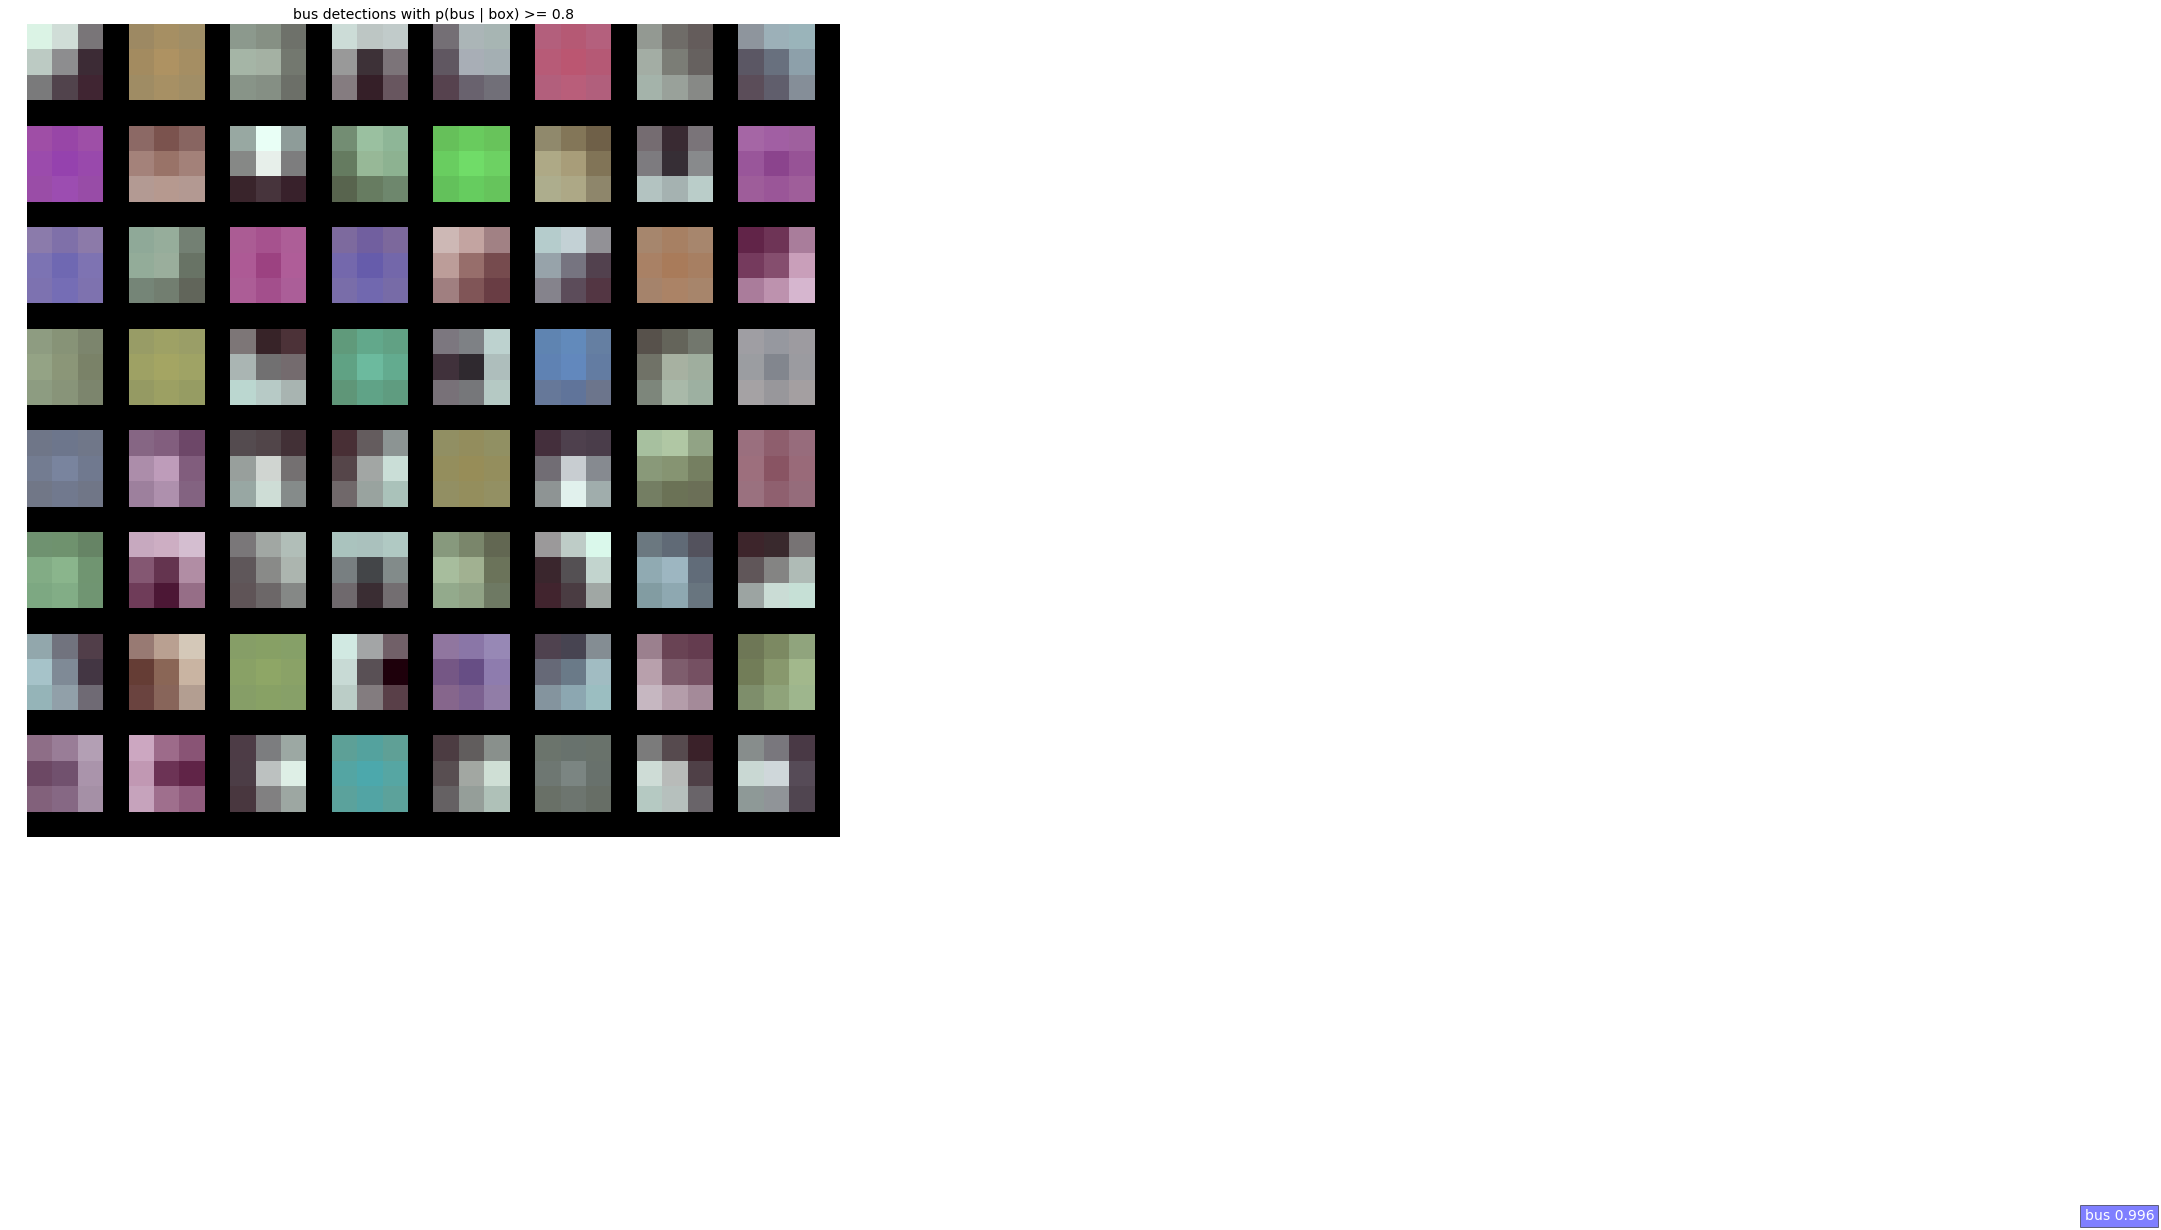

TypeError: Invalid dimensions for image data

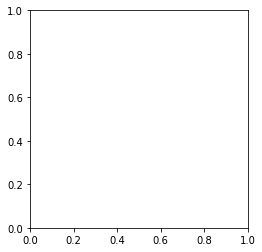

In [15]:
#!/usr/bin/env python

# --------------------------------------------------------
# Faster R-CNN
# Copyright (c) 2015 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ross Girshick
# --------------------------------------------------------

"""
Demo script showing detections in sample images.

See README.md for installation instructions before running.
"""

import os
import sys
import argparse

import cv2
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

import tools._init_paths
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import caffe



def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()

    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))

    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])

    plt.imshow(data)
    plt.show()
    
    
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0],
                bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14,
                color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()



def demo(net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""
    
    print "demo:"

    # Load the demo image
    # image path: data/demo/*.jpg
    image_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
    image = cv2.imread(image_file)
    print "image: ", image

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(net, image)
    timer.toc()
    print ('Detection took {:.3f}s for '
           '{:d} object proposals').format(timer.total_time, boxes.shape[0])

    # Visualize detections for each class
    CONF_THRESH = 0.8
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        detections = np.hstack((cls_boxes,cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(detections, NMS_THRESH)
        detections = detections[keep, :]
        vis_detections(image, cls, detections, thresh=CONF_THRESH)


def main():

    cfg.TEST.HAS_RPN = True  # Use RPN for proposals
    caffemodel = "/home/kelly/Studio/westwell/DeepBrain/fasterrcnn_caffe/fasterrcnn/py-faster-rcnn/data/faster_rcnn_models/VGG16_faster_rcnn_final.caffemodel"
    prototxt = "/home/kelly/Studio/westwell/DeepBrain/fasterrcnn_caffe/fasterrcnn/py-faster-rcnn/models/pascal_voc/VGG16/faster_rcnn_alt_opt/faster_rcnn_test.pt"                

    if not os.path.isfile(caffemodel):
        raise IOError(('{:s} not found.\nDid you run ./data/script/'
                       'fetch_faster_rcnn_models.sh?').format(caffemodel))

    # device mode
    caffe.set_mode_cpu()

    # initializing net
    net = caffe.Net(prototxt, caffemodel, caffe.TEST)
    print '\n\nLoaded network {:s}'.format(caffemodel)

    # Warmup on a dummy image
    # image = 128 * np.ones((300, 500, 3), dtype=np.uint8)
    # for i in xrange(2):
    #     _, _= im_detect(net, image)

    # im_names = ['000456.jpg', '000542.jpg', '001150.jpg', '001763.jpg', '004545.jpg']
    image_names = ['000456.jpg']
    for image_name in image_names:
        print '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
        print 'Demo for data/demo/{}'.format(image_name)
        demo(net, image_name)

    #根据每一层的名称，选择需要可视化的层，可以可视化filter（参数）和output（特征）
    # the parameters are a list of [weights, biases],各层的特征，第一个卷积层，共96个过滤器
    filters = net.params['conv1_1'][0].data
    vis_square(filters.transpose(0, 2, 3, 1))

    filters = net.params['conv2_1'][0].data
    vis_square(filters.transpose(0, 2, 3, 1))
    
    plt.show()


if __name__ == '__main__':
    main()